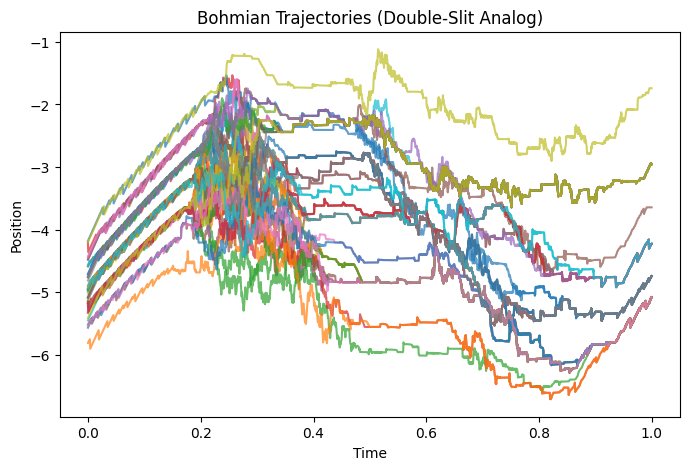

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Constants (in atomic units for simplicity, or choose appropriate scaling)
hbar = 1.0      # Reduced Planck's constant
m = 1.0          # Particle mass
# You might adapt units so that hbar = m = 1, and the spatial/time scale are dimensionless.

# Spatial/Temporal Grid Parameters
N = 2048          # Number of spatial points
L = 20.0          # Spatial domain length
dx = L / N
x = np.linspace(-L/2, L/2, N, endpoint=False)

dt = 0.0005        # Time step
steps = 2000      # Number of time steps to evolve

# Define the initial wavepacket
# A Gaussian wave packet approaching the slits
x0 = -5.0   # initial center
p0 = 20.0   # initial momentum (sets velocity towards slits)
sigma = 0.5 # width of packet

def gaussian_packet(x, x0, p0, sigma):
    return (1.0/(sigma*np.sqrt(np.pi)))**0.5 * np.exp(-(x - x0)**2/(2*sigma**2) + 1j*p0*(x - x0)/hbar)

psi = gaussian_packet(x, x0, p0, sigma)

# Define the potential for the double-slit
# Let's create a barrier at x = 0 with two slits at certain y positions.
# In 1D we can only show a barrier along x, but in a full 2D scenario you would define V(x,y).
# For demonstration, we consider a 1D analog: a barrier with small "notches" where the particle can pass.
# This is purely illustrative.

# For a 1D analogy, we must treat the slits as regions of zero potential separated by barriers.
# Let's say we have a barrier from -0.2 < x < 0.2 except at two small slits around -0.05 and 0.05:
V0 = 1e5  # Large potential to simulate impenetrable barrier
barrier_width = 0.4
slit_width = 0.05
slit_positions = [-0.1, 0.1]  # Two slits at -0.1 and 0.1

V = np.zeros_like(x)
for i, xi in enumerate(x):
    if np.abs(xi) < barrier_width/2:
        # Check if xi is within a slit
        in_slit = False
        for sp in slit_positions:
            if np.abs(xi - sp) < slit_width/2:
                in_slit = True
                break
        if not in_slit:
            V[i] = V0

# For a triple-slit, just define three slit positions, e.g. slit_positions = [-0.1, 0.0, 0.1] and do the same.

# Precompute kinetic evolution operator in momentum space (Split-step method)
# Momentum space grid
dk = 2*np.pi/L
k = np.fft.fftfreq(N, d=dx)*2*np.pi

# Time evolution operators
U_kin = np.exp(-1j*(hbar/(2*m))*k**2 * dt/hbar)
U_pot = np.exp(-1j*V*dt/hbar)

# Function to evolve one time step
def evolve(psi):
    # half step potential
    psi = U_pot**0.5 * psi
    # full step kinetic in k-space
    psi_k = np.fft.fft(psi)
    psi_k = U_kin * psi_k
    psi = np.fft.ifft(psi_k)
    # another half step potential
    psi = U_pot**0.5 * psi
    return psi

# Initialize particle positions for Bohmian trajectories
# We sample according to initial probability distribution |psi|^2.
num_particles = 50
prob_density = np.abs(psi)**2
prob_density /= np.sum(prob_density)
particle_positions = np.random.choice(x, size=num_particles, p=prob_density)

# To store trajectories
trajectories = np.zeros((steps, num_particles))
trajectories[0,:] = particle_positions

# Bohmian velocity field:
# v = (hbar/m) * Im(\grad psi / psi) = (hbar/m) * (∂φ/∂x) where psi = |psi| e^{iφ}
#
# Numerically:
# φ(x) = arg(psi(x))
# v(x) = (hbar/m) * ∂φ/∂x
#
# We'll compute this every step to move the particles.

def compute_velocity(psi):
    phase = np.angle(psi)
    # numerical derivative of phase
    dphase_dx = np.gradient(phase, dx)
    v = (hbar/m)*dphase_dx
    return v

# Time evolution
for i in range(1, steps):
    # Evolve wavefunction
    psi = evolve(psi)
    # Compute velocity field
    v = compute_velocity(psi)
    
    # Interpolate velocity to particle positions
    # Since particle_positions may not lie exactly on grid points, we do a simple linear interpolation
    # For better accuracy, consider a higher order interpolation.
    particle_indices = np.searchsorted(x, particle_positions)
    particle_indices = np.clip(particle_indices, 1, N-1)
    x_left = x[particle_indices-1]
    x_right = x[particle_indices]
    v_left = v[particle_indices-1]
    v_right = v[particle_indices]
    
    # Linear interpolation of velocity
    w = (particle_positions - x_left)/(x_right - x_left)
    particle_velocities = v_left*(1-w) + v_right*w
    
    # Update particle positions
    particle_positions = particle_positions + particle_velocities*dt
    
    # Store trajectories
    trajectories[i,:] = particle_positions


# Plot final trajectories
fig, ax = plt.subplots(figsize=(8,5))
for n in range(num_particles):
    ax.plot(np.arange(steps)*dt, trajectories[:,n], alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.set_title('Bohmian Trajectories (Double-Slit Analog)')
plt.show()

# For a 2D scenario (true double-slit diffraction pattern), one would need to:
# 1. Solve the 2D Schrödinger equation on a 2D grid.
# 2. Place a barrier with two slits along the y-axis at x=0.
# 3. Sample initial particle positions in the 2D wavefront.
# 4. Compute gradient of the phase in both x and y directions to get the velocity field.
# 5. Integrate particle paths in 2D.
#
# That is more complex and computationally intensive, but the principle remains the same.


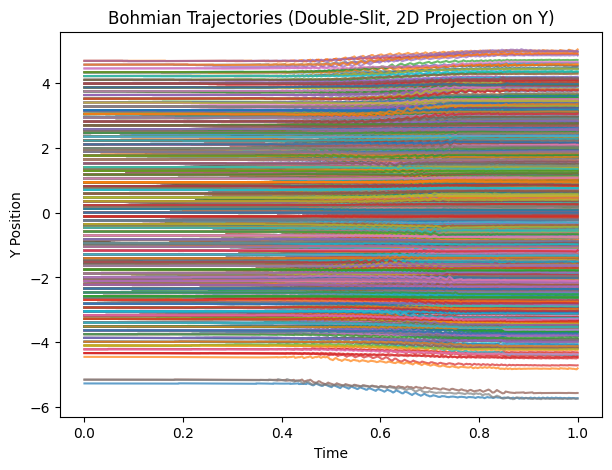

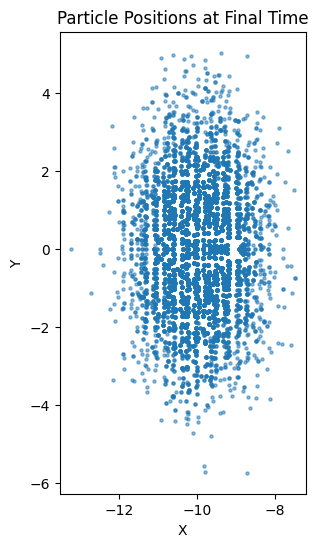

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set constants and parameters (dimensionless units)
hbar = 1.0
m = 1.0

# Spatial grid
Nx = 256
Ny = 256
Lx = 30.0
Ly = 30.0
dx = Lx / Nx
dy = Ly / Ny

x = np.linspace(-Lx/2, Lx/2, Nx, endpoint=False)
y = np.linspace(-Ly/2, Ly/2, Ny, endpoint=False)
X, Y = np.meshgrid(x, y, indexing='ij')

# Time parameters
dt = 0.0005
steps = 2000

# Initial wavefunction: A Gaussian wave packet moving in +x direction
x0 = -10.0
y0 = 0.0
px0 = 30.0  # momentum in x
py0 = 0.0
sigma_x = 1.0
sigma_y = 2.0

def gaussian_2d(X, Y, x0, y0, sigma_x, sigma_y, px0, py0):
    # psi(x,y) = normalization * exp(-( (x - x0)^2/(2 sigma_x^2) + (y - y0)^2/(2 sigma_y^2) ))
    # * exp(i(px0(x - x0) + py0(y - y0))/hbar)
    norm = 1.0/(2*np.pi*sigma_x*sigma_y)**0.5
    return norm * np.exp(-((X - x0)**2/(2*sigma_x**2) + (Y - y0)**2/(2*sigma_y**2))) \
           * np.exp(1j*(px0*(X - x0) + py0*(Y - y0))/hbar)

psi = gaussian_2d(X, Y, x0, y0, sigma_x, sigma_y, px0, py0)

# Define the double-slit potential
# Barrier at x=0. Two slits along y-axis.
V0 = 1000.0
barrier_width = dx
slit_half_width = 0.5
slit_centers = [-1.0, 1.0]  # positions of slit centers in y

V = np.zeros((Nx, Ny))
for i in range(Nx):
    for j in range(Ny):
        if abs(x[i]) < barrier_width/2:
            # Check if this y is in a slit
            in_slit = False
            for sc in slit_centers:
                if abs(y[j] - sc) < slit_half_width:
                    in_slit = True
                    break
            if not in_slit:
                V[i,j] = V0

# Prepare for split-step Fourier method
kx = 2*np.pi * np.fft.fftfreq(Nx, d=dx)
ky = 2*np.pi * np.fft.fftfreq(Ny, d=dy)
KX, KY = np.meshgrid(kx, ky, indexing='ij')

# Kinetic operator in momentum space
U_kin = np.exp(-1j * (hbar/(2*m)) * (KX**2 + KY**2) * dt/hbar)

# Potential operator in real space
U_pot = np.exp(-1j*V*dt/hbar)

def evolve(psi):
    # half potential step
    psi = U_pot**0.5 * psi
    # kinetic step
    psi_k = np.fft.fftn(psi)
    psi_k = U_kin * psi_k
    psi = np.fft.ifftn(psi_k)
    # half potential step
    psi = U_pot**0.5 * psi
    return psi

# Initialize particles
num_particles = 10000
prob = np.abs(psi)**2
prob /= np.sum(prob)
indices = np.random.choice(Nx*Ny, size=num_particles, p=prob.ravel())
particles_x = X.ravel()[indices]
particles_y = Y.ravel()[indices]

# Storage for trajectories
trajectories_x = np.zeros((steps, num_particles))
trajectories_y = np.zeros((steps, num_particles))
trajectories_x[0,:] = particles_x
trajectories_y[0,:] = particles_y

def compute_velocity(psi):
    # Compute phase and gradient
    # phase = arg(psi)
    phase = np.angle(psi)
    dphase_dx = np.gradient(phase, dx, axis=0)
    dphase_dy = np.gradient(phase, dy, axis=1)
    vx = (hbar/m)*dphase_dx
    vy = (hbar/m)*dphase_dy
    return vx, vy

for i in range(1, steps):
    psi = evolve(psi)
    vx, vy = compute_velocity(psi)
    
    # Interpolate velocities to particle positions
    # Find nearest grid indices
    ix = np.searchsorted(x, particles_x)
    iy = np.searchsorted(y, particles_y)
    ix = np.clip(ix, 1, Nx-1)
    iy = np.clip(iy, 1, Ny-1)
    
    # Bilinear interpolation of velocities
    x1 = x[ix-1]; x2 = x[ix]
    y1 = y[iy-1]; y2 = y[iy]
    dx1 = (particles_x - x1)/(x2 - x1)
    dy1 = (particles_y - y1)/(y2 - y1)
    
    v11x = vx[ix-1, iy-1]; v12x = vx[ix-1, iy]
    v21x = vx[ix, iy-1];   v22x = vx[ix, iy]
    interp_vx = v11x*(1-dx1)*(1-dy1) + v21x*dx1*(1-dy1) + v12x*(1-dx1)*dy1 + v22x*dx1*dy1

    v11y = vy[ix-1, iy-1]; v12y = vy[ix-1, iy]
    v21y = vy[ix, iy-1];   v22y = vy[ix, iy]
    interp_vy = v11y*(1-dx1)*(1-dy1) + v21y*dx1*(1-dy1) + v12y*(1-dx1)*dy1 + v22y*dx1*dy1

    # Update particle positions
    particles_x += interp_vx * dt
    particles_y += interp_vy * dt

    trajectories_x[i,:] = particles_x
    trajectories_y[i,:] = particles_y

# Plot the final trajectories
fig, ax = plt.subplots(figsize=(7,5))
for n in range(num_particles):
    ax.plot(np.arange(steps)*dt, trajectories_y[:,n], alpha=0.7)
ax.set_xlabel('Time')
ax.set_ylabel('Y Position')
ax.set_title('Bohmian Trajectories (Double-Slit, 2D Projection on Y)')
plt.show()

# For a more visually intuitive picture, you might want to:
# - Plot particle trajectories in the 2D (x,y) plane.
# - Animate their motion as time progresses.
# - Visualize the probability density |psi|^2 as a background.

# For example, to plot in 2D plane at the final time:
fig2, ax2 = plt.subplots(figsize=(6,6))
ax2.scatter(trajectories_x[-1,:], trajectories_y[-1,:], s=5, alpha=0.5)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Particle Positions at Final Time')
ax2.set_aspect('equal')
plt.show()


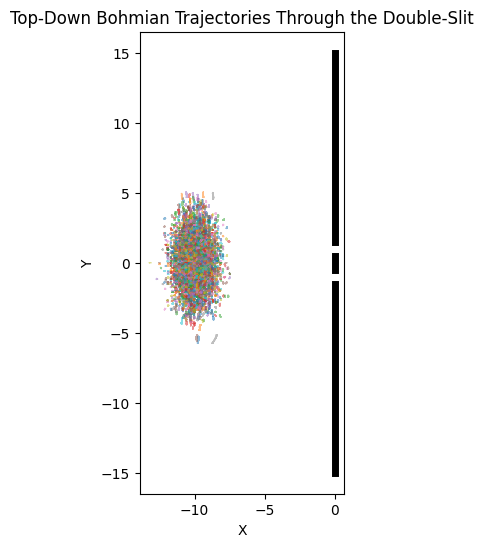

In [7]:
# Plot the top-down trajectories over time
fig3, ax3 = plt.subplots(figsize=(6,6))

# Plot each particle's trajectory as a line
for n in range(num_particles):
    ax3.plot(trajectories_x[:,n], trajectories_y[:,n], alpha=0.5, linewidth=1)

# Draw the barrier line with slits as before
barrier_x = 0.0
barrier_y_min = -Ly/2
barrier_y_max = Ly/2
slit_centers = sorted(slit_centers)

barrier_segments = []
current_start = barrier_y_min
for sc in slit_centers:
    slit_start = sc - slit_half_width
    slit_end = sc + slit_half_width
    # segment before this slit
    barrier_segments.append((current_start, slit_start))
    current_start = slit_end
barrier_segments.append((current_start, barrier_y_max))

for (y1, y2) in barrier_segments:
    ax3.plot([barrier_x, barrier_x], [y1, y2], 'k', linewidth=5)

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_title('Top-Down Bohmian Trajectories Through the Double-Slit')
ax3.set_aspect('equal')
plt.show()


## New Approach

/var/folders/yj/gnbff_r55s7fw6ylhj7q526r0000gn/T/ipykernel_81327/2094204242.py:28: RuntimeWarning: divide by zero encountered in divide
  v_grid = (hbar/m)*np.imag(dpsi_dx/psi_grid)


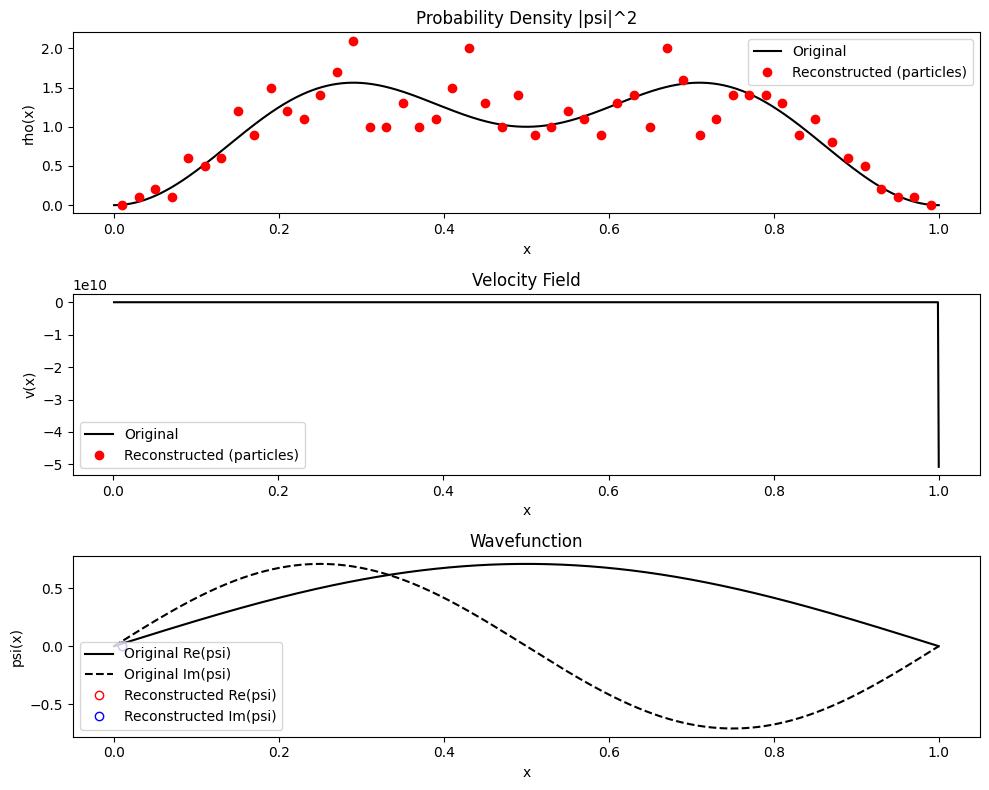

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_trapezoid  # Use cumulative_trapezoid instead of cumtrapz

# Parameters
L = 1.0
hbar = 1.0
m = 1.0

# Define the known wavefunction
def psi(x):
    # Superposition: (sin(pi*x) + i*sin(2*pi*x))/sqrt(2)
    c1 = 1.0/np.sqrt(2)
    c2 = 1.0/np.sqrt(2)
    return c1*np.sin(np.pi*x) + 1j*c2*np.sin(2*np.pi*x)

# Define a grid
Ngrid = 1000
x_grid = np.linspace(0, L, Ngrid)

psi_grid = psi(x_grid)
rho_grid = np.abs(psi_grid)**2

# Compute the derivative of psi to get the velocity field
# v(x) = (hbar/m)*Im[(d/dx psi)/psi]
dpsi_dx = np.gradient(psi_grid, x_grid)
v_grid = (hbar/m)*np.imag(dpsi_dx/psi_grid)

# Normalize just to be safe (should already be normalized)
normalization = np.trapz(rho_grid, x_grid)
rho_grid /= normalization

###############################
# Synthetic particle generation
###############################
Nparticles = 500

# Sample particle positions from rho(x)
cdf = np.cumsum(rho_grid)
cdf /= cdf[-1]
uniform_randoms = np.random.rand(Nparticles)
particle_positions = np.interp(uniform_randoms, cdf, x_grid)

# Assign each particle a velocity based on their position
v_interp = interp1d(x_grid, v_grid, kind='cubic', fill_value="extrapolate")
particle_velocities = v_interp(particle_positions)

#################################
# Reconstruction from Particles
#################################

# Step 1: Estimate rho(x) from particles
num_bins = 50
hist, bin_edges = np.histogram(particle_positions, bins=num_bins, range=(0,L), density=True)
x_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
rho_est = hist

# Step 2: Estimate v(x) from particles
sort_idx = np.argsort(particle_positions)
x_sorted = particle_positions[sort_idx]
v_sorted = particle_velocities[sort_idx]

v_est_interp = interp1d(x_sorted, v_sorted, kind='linear', bounds_error=False, fill_value="extrapolate")
v_est = v_est_interp(x_centers)

# Step 3: Integrate to find S(x)
# v(x) = (1/m)*dS/dx => dS = m*v(x)*dx
S_est = m*cumulative_trapezoid(v_est, x_centers, initial=0.0)

# Adjust S by subtracting its value at the left boundary (for convenience)
S_est -= S_est[0]

# Step 4: Reconstruct psi
psi_amp = np.sqrt(rho_est)
psi_phase = S_est/hbar
psi_recon = psi_amp * np.exp(1j*psi_phase)

# Interpolate original psi onto x_centers for comparison
psi_orig_real = np.interp(x_centers, x_grid, psi_grid.real)
psi_orig_imag = np.interp(x_centers, x_grid, psi_grid.imag)
psi_orig_interp = psi_orig_real + 1j*psi_orig_imag

###############################
# Plot results
###############################
plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(x_grid, rho_grid, 'k-', label='Original')
plt.plot(x_centers, rho_est, 'ro', label='Reconstructed (particles)')
plt.title('Probability Density |psi|^2')
plt.xlabel('x')
plt.ylabel('rho(x)')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x_grid, v_grid, 'k-', label='Original')
plt.plot(x_centers, v_est, 'ro', label='Reconstructed (particles)')
plt.title('Velocity Field')
plt.xlabel('x')
plt.ylabel('v(x)')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x_grid, psi_grid.real, 'k-', label='Original Re(psi)')
plt.plot(x_grid, psi_grid.imag, 'k--', label='Original Im(psi)')
plt.plot(x_centers, psi_recon.real, 'ro', fillstyle='none', label='Reconstructed Re(psi)')
plt.plot(x_centers, psi_recon.imag, 'bo', fillstyle='none', label='Reconstructed Im(psi)')
plt.title('Wavefunction')
plt.xlabel('x')
plt.ylabel('psi(x)')
plt.legend()

plt.tight_layout()
plt.show()